In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

# ========== Config ==========
T = 1000
BATCH_SIZE = 64
NUM_CLASSES = 10

LR = 1e-4
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

# ========== Beta schedule ==========
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

# ========== Dataset ==========
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# ========== Model ==========
class ConditionalDDPM(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 64, 3, padding=1)  # 3 channels + 1 conditioning
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 3, 3, padding=1)

        self.time_emb = nn.Embedding(T, 64)
        self.class_emb = nn.Embedding(num_classes, 64)

    def forward(self, x, t, y):
        t_emb = self.time_emb(t)
        y_emb = self.class_emb(y)
        cond = (t_emb + y_emb).view(x.size(0), 64, 1, 1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, cond[:, :1]], dim=1)  # condition using only 1 channel
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return self.conv4(x)

model = ConditionalDDPM(num_classes=NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ========== Forward diffusion ==========
def forward_diffusion_sample(x_0, t, device):
    noise = torch.randn_like(x_0)
    
    # Move the lookup table to the correct device BEFORE indexing
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod.to(device)[t][:, None, None, None]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.to(device)[t][:, None, None, None]
    
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise



In [ ]:
epochs = 400

# ========== Training ==========
print("🚀 Starting training...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}"):
        x = x.to(device)
        y = y.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device).long()
        x_noisy, noise = forward_diffusion_sample(x, t, device)
        noise_pred = model(x_noisy, t, y)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(trainloader):.4f}")
    if (epoch + 1) % 50 == 0:
        torch.save(model.state_dict(), f'checkpoint_epoch{epoch+1}.pth')

print("✅ Training complete!")

PATH = f'./conditional_ddpm_cfar10_by_image_epochs{epochs}.pth'
torch.save(model.state_dict(), PATH)

In [11]:
# ========== Sampling from real image ==========
def denoise_from_image(x_start, label, net):
    x = x_start.clone()
    net.eval()
    with torch.no_grad():
        for i in reversed(range(T)):
            t = torch.full((1,), i, device=device, dtype=torch.long)
            beta = betas[i]
            alpha = alphas[i]
            alpha_hat = alphas_cumprod[i]

            noise_pred = net(x, t, label)
            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0

            x = (1 / torch.sqrt(alpha)) * (
                x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * noise_pred
            ) + torch.sqrt(beta) * noise
    return x

def show_images(original, noisy, generated):
    imgs = torch.cat([original, noisy, generated], dim=0)
    imgs = (imgs.clamp(-1, 1) + 1) / 2  # unnormalize
    grid = make_grid(imgs, nrow=3)
    plt.figure(figsize=(9, 3))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title("Original | Noisy | Denoised")
    plt.axis("off")
    plt.show()

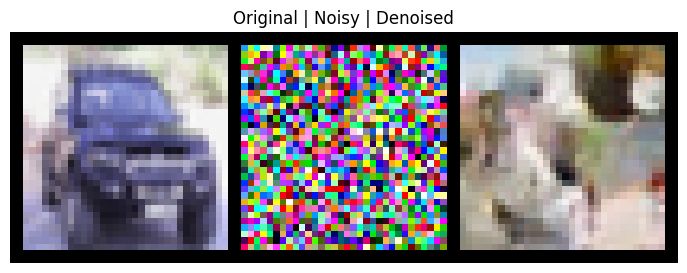

In [27]:
# Get real image
testset = datasets.CIFAR10(root='./data', train=False, transform=transform)
real_img, real_label = testset[9]
real_img = real_img.unsqueeze(0).to(device)
real_label = torch.tensor([real_label], device=device)

net = ConditionalDDPM(num_classes=NUM_CLASSES).to(device)
PATH = f'./conditional_ddpm_cfar10_by_image_epochs{epochs}.pth'
checkpoint = torch.load(PATH, map_location=device)
net.load_state_dict(checkpoint)

# Add noise at t = T-1
t = torch.tensor([T - 1], device=device)
noisy_img, _ = forward_diffusion_sample(real_img, t, device)

# Generate from noisy image
generated_img = denoise_from_image(noisy_img, real_label, net)


show_images(real_img, noisy_img, generated_img)

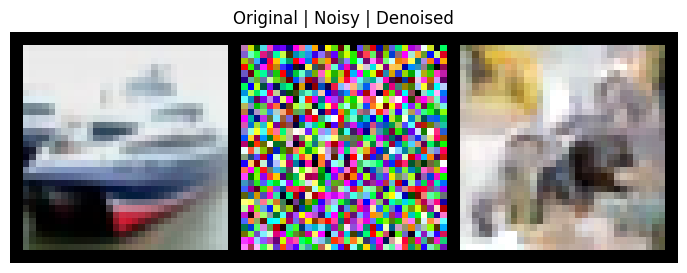

In [29]:
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
# Get real image
testset = datasets.CIFAR10(root='./data', train=False, transform=transform)
real_img, real_label = testset[1]
real_img = real_img.unsqueeze(0).to(device)
real_label = torch.tensor([real_label], device=device)

net = ConditionalDDPM(num_classes=NUM_CLASSES).to(device)
PATH = f'./conditional_ddpm_cfar10_by_image_epochs400.pth'
checkpoint = torch.load(PATH, map_location=device)
net.load_state_dict(checkpoint)

# Add noise at t = T-1
t = torch.tensor([T - 1], device=device)
noisy_img, _ = forward_diffusion_sample(real_img, t, device)

# Generate from noisy image
generated_img = denoise_from_image(noisy_img, real_label, net)


show_images(real_img, noisy_img, generated_img)